# 人工智慧導論及實作 LAB2

*   評分標準:
1. 程式整體完整 - 基本分 60%
2. 結案報告 - 30%
3. Accruacy - 依照全班分布給分 10%


Accuracy 必須依照規定的格式 (.csv) 輸出
否則不予計分

Dataset 下載連結 https://drive.google.com/file/d/1iJwpxU9IdO4h-cxzU0Zju67TPnoqLbr0/view?usp=share_link

# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
# connect to self-drive
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


Specify the path to the destination folder, where you upload your data.

In [3]:
import os
GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/Lab2'
print(os.listdir(GOOGLE_DRIVE_PATH))

['Bangla.zip']


# Data processing

### Unzip data to destination path

!unzip ZIP_SOURCE -d DESTINATION

In [4]:
! cp '/content/drive/MyDrive/Lab2/Bangla.zip' /content/
!unzip 'Bangla.zip' -d '/content'

Archive:  Bangla.zip
  inflating: /content/bangla_banknote_v2/Testing/0.jpg  
  inflating: /content/bangla_banknote_v2/Testing/1.jpg  
  inflating: /content/bangla_banknote_v2/Testing/10.jpg  
  inflating: /content/bangla_banknote_v2/Testing/100.jpg  
  inflating: /content/bangla_banknote_v2/Testing/101.jpg  
  inflating: /content/bangla_banknote_v2/Testing/102.jpg  
  inflating: /content/bangla_banknote_v2/Testing/103.jpg  
  inflating: /content/bangla_banknote_v2/Testing/104.jpg  
  inflating: /content/bangla_banknote_v2/Testing/105.jpg  
  inflating: /content/bangla_banknote_v2/Testing/106.jpg  
  inflating: /content/bangla_banknote_v2/Testing/107.jpg  
  inflating: /content/bangla_banknote_v2/Testing/108.jpg  
  inflating: /content/bangla_banknote_v2/Testing/109.jpg  
  inflating: /content/bangla_banknote_v2/Testing/11.jpg  
  inflating: /content/bangla_banknote_v2/Testing/110.jpg  
  inflating: /content/bangla_banknote_v2/Testing/111.jpg  
  inflating: /content/bangla_banknote_v2/

### Import the necessary library

In [5]:
# import the package which we will use to programing 
import os
import csv
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
import random
import matplotlib.pyplot as plt
import pandas as pd 
import torch.optim as optim
import math

from PIL import Image
from google.colab import drive
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from torchvision import datasets

In [6]:
import matplotlib.pyplot as plt
img = plt.imread('/content/bangla_banknote_v2/Testing/0.jpg')
print(img.shape)

(120, 250, 3)


### Device
The using device below should be "cuda:0" as 


```
Use device: cuda:0
```


We advice using cuda to train which is much quicker than cpu only in training process.

If not, please check and change the setting below

**Edit -> Notebook settings -> Hardware accelerator -> GPU**


In [7]:
# use gpu if you have
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Use device:",device)

# set random seed
SEED = 6071
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

Use device: cuda:0


### DataLoader

Here should do some processes on your data, we can apply the augmentation functions to make our data have more diversity which may be helpful to the accuracy.

**You have to implement at least one augmentation method and explain the reason why you choose it in your report.**


In [8]:
# you need change image to tensor
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])


Specify the path to the training folder.

Here is going to get images path and labels data which will be used in the Custom_dataset

In [9]:
# Specify the path to the training folder.
TRAINDATA_PATH = '/content/bangla_banknote_v2/Training'

label_name = {"1": 0, "2": 1, "5": 2, "10": 3, "20": 4, "50": 5, "100": 6, "500": 7, "1000": 8}

def get_img_info(data_dir):
        imgpath = []
        imglabel = []
        for root, dirs, _ in os.walk(data_dir):
            # Traverse categories
            for sub_dir in dirs:
                img_names = os.listdir(os.path.join(root, sub_dir))
                img_names = list(filter(lambda x: x.endswith('.jpg'), img_names))
 
                # Traverse images
                for i in range(len(img_names)):
                    img_name = img_names[i]
                    path_img = os.path.join(root, sub_dir, img_name)
                    label = label_name[sub_dir]
                    imgpath.append(path_img)
                    imglabel.append(int(label))
        
        # Return image paths and labels in data_info
        return imgpath,  imglabel

imgpath,  imglabel = get_img_info(TRAINDATA_PATH)

In [10]:
class Custom_dataset(Dataset):
    def __init__(self,trainData,trainLabel,transform=None):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        self.images = trainData
        self.label = trainLabel
        self.transform = transform
        
    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        imgpath = self.images[index]
        img = Image.open(imgpath).convert('RGB')
        
        label = self.label[index]
        if self.transform:
          img = self.transform(img)

        return img, label
        
    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.images)

### Please Change the batch_size in DataLoader

batch_size will also affect training step.

higher: faster, stable

but inprecise on optimize, may use large memory

**You should change the appropriate batch size.**

**The validation set has already done**

In [11]:
# Spilt the train and valid data
train_img, val_img, train_label, val_label = train_test_split(imgpath, imglabel, test_size=0.2, random_state=42)

train_set = Custom_dataset(train_img, train_label, transform=train_transform)
valid_set = Custom_dataset(val_img, val_label, transform=valid_transform)

print('Number of total training data:', len(train_set))
print('Number of total validation data:', len(valid_set))

class_num = 9
classes = ('1', '10', '100', '1000', '2', '20', '5', '50', '500')

# Loaded Datasets to DataLoaders
##############################################################################
#                    TODO: Validation Dataloader                             #
##############################################################################

# please change the batch_size
trainloader = DataLoader(train_set, batch_size= 32, shuffle=True, num_workers = 2)
validloader = DataLoader(valid_set, batch_size= 32, shuffle=False, num_workers = 2)

##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

Number of total training data: 1309
Number of total validation data: 328


### View the picture from dataset


Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])


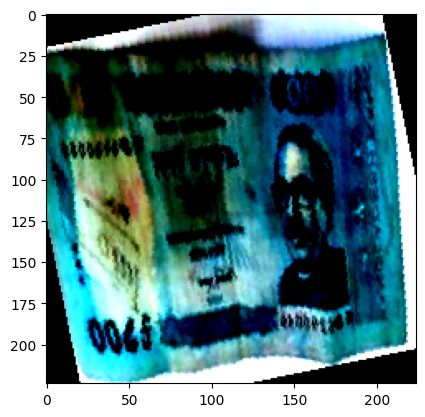

Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])


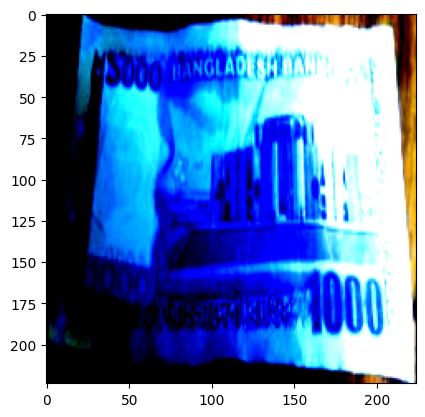

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Checking the dataset
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for img,labels in trainloader:
    # load a batch from train data
    break

# this converts it from GPU to CPU and selects first image
img = img.cpu().numpy()[0]
#convert image back to Height,Width,Channels
img = np.transpose(img, (1,2,0))
#show the image
plt.imshow(img)
plt.show()  

for images, labels in validloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for img_test,labels in validloader:
    # load a batch from train data
    break

# this converts it from GPU to CPU and selects first image
img_test = img_test.cpu().numpy()[0]
#convert image back to Height,Width,Channels
img_test = np.transpose(img_test, (1,2,0))
#show the image
plt.imshow(img_test)
plt.show()  


# Model


Implement VGG-16 structure.

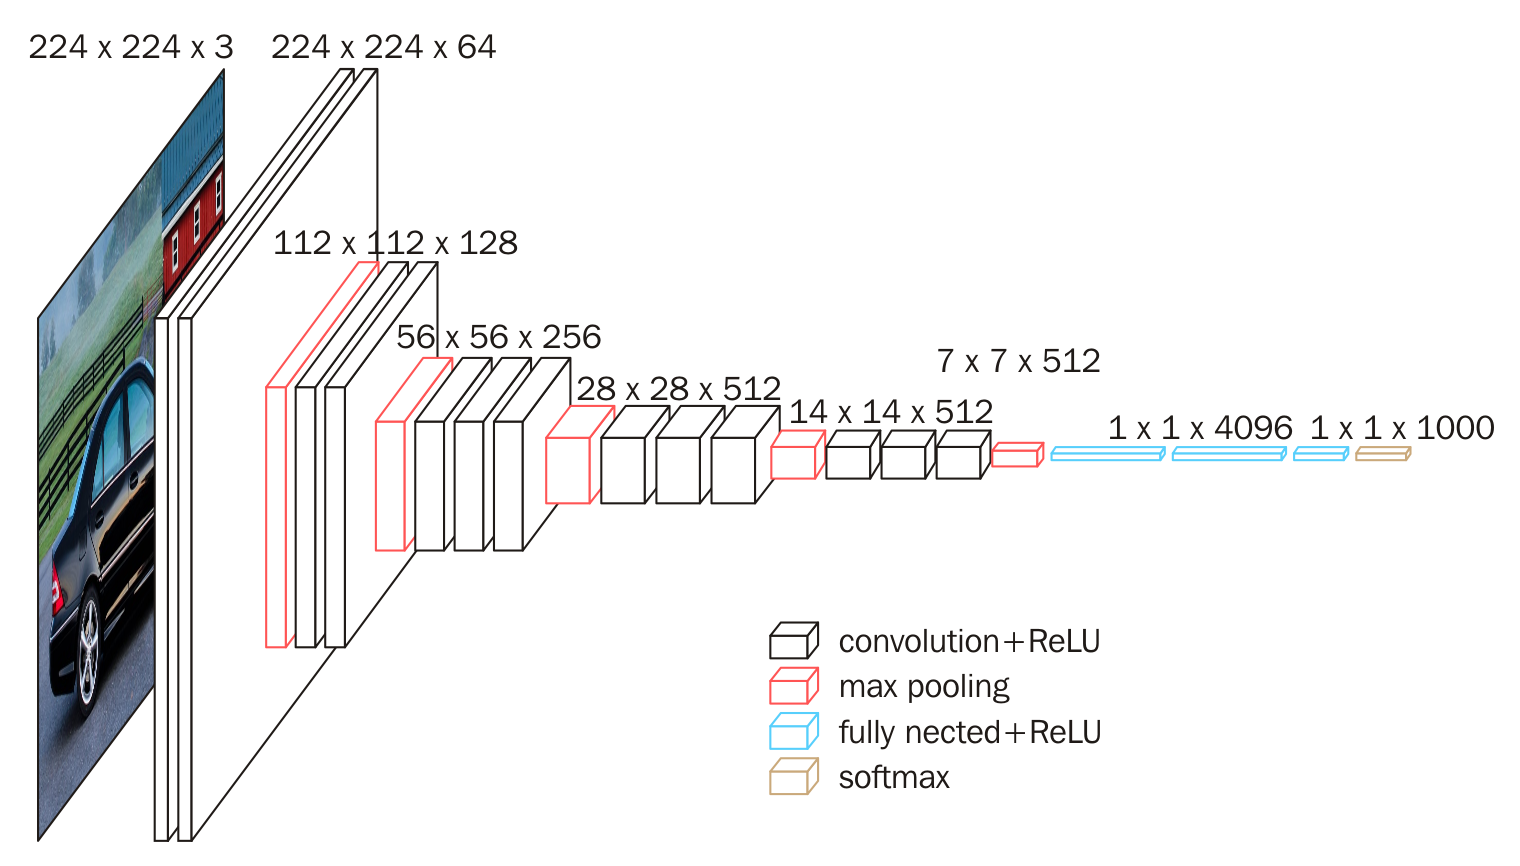

In [13]:
##############################################
# Build your model here!
# 
# Practice:
#   Try to implement VGG-16 with pytorch !
##############################################

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1000)
        )


    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = VGG16()
model.to(device)

VGG16(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(

### Parameter setting 
Please change your own optimizer, learning rate and epochs.

In [14]:
## Use GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)   
epochs = 30
         
model.train()

cuda:0


VGG16(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(

### Loading model



Due to the longer training time required for this assignment, if your Colab runtime exceeds its limits during training, we have pre-saved the best performing model at the end of each epoch. 

You can load the model here.

Please change the WEIGHT_PATH to the specify path.

In [15]:
try:  
  WEIGHT_PATH = '/content/drive/MyDrive/Lab2/model_weight.pth'
  checkpoint = torch.load(WEIGHT_PATH , map_location="cuda:0")
  model.load_state_dict(checkpoint)
except:
  pass

# Training
Here is the main process to train your model, we have already completed the validation function.

To prevent data loss in case of mid-training interruptions, we save the model weight at the best performance of each training session.

If you need to load the model, please refer to the following documentation.

https://pytorch.org/tutorials/beginner/saving_loading_models.html

Please set SAVING_PATH to the desired location you want to configure.

In [16]:
# Training model
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

# Specify the saving weight path
SAVING_PATH = '/content/drive/MyDrive/Lab2'

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, epochs+1):# loop over the dataset multiple times

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    
    # train the model 
    model.train()
    train_correct = 0
    train_total = 0
    for data, target in tqdm(trainloader):
      # move tensors to GPU if CUDA is available
      data, target = data.to(device), target.to(device)
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # update training loss
      train_loss += loss.item()*data.size(0)
      # update training Accuracy
      train_total += target.size(0)
      _, predicted = torch.max(output.data, 1)
      train_correct += (predicted == target).sum().item()
      

    # validate the model
    model.eval()
    valid_correct = 0
    valid_total = 0
    for data, target in tqdm(validloader):
        # move tensors to GPU if CUDA is available
        target = target.long()
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        # update validation Accuracy
        valid_total += target.size(0)
        _, predicted = torch.max(output.data, 1)
        valid_correct += (predicted == target).sum().item()
    # calculate average losses
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(validloader.dataset)
        
    # print training/validation statistics 
    print('Training Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(train_loss,(100 * train_correct / train_total)))
    print('Validation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(valid_loss,(100 * valid_correct / valid_total)))
    
    train_loss_list.append(train_loss)
    train_acc_list.append(100 * train_correct / train_total)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(100 * valid_correct / valid_total)

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), SAVING_PATH+'/model_weight.pth')
        valid_loss_min = valid_loss

print('Finished Training')


running epoch: 1


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 3.352126 	Training Accuracy: 12.605042
Validation Loss: 2.254076 	Validation Accuracy: 11.585366
Validation loss decreased (inf --> 2.254076).  Saving model ...
running epoch: 2


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 2.272555 	Training Accuracy: 12.375859
Validation Loss: 2.295843 	Validation Accuracy: 8.841463
running epoch: 3


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 2.239179 	Training Accuracy: 13.216196
Validation Loss: 2.241004 	Validation Accuracy: 10.975610
Validation loss decreased (2.254076 --> 2.241004).  Saving model ...
running epoch: 4


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 2.232674 	Training Accuracy: 13.445378
Validation Loss: 2.250165 	Validation Accuracy: 13.109756
running epoch: 5


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 2.239688 	Training Accuracy: 10.007639
Validation Loss: 2.232595 	Validation Accuracy: 13.109756
Validation loss decreased (2.241004 --> 2.232595).  Saving model ...
running epoch: 6


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 2.218167 	Training Accuracy: 13.368984
Validation Loss: 2.235259 	Validation Accuracy: 8.841463
running epoch: 7


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 2.223686 	Training Accuracy: 12.757830
Validation Loss: 2.205767 	Validation Accuracy: 10.975610
Validation loss decreased (2.232595 --> 2.205767).  Saving model ...
running epoch: 8


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 2.212240 	Training Accuracy: 11.611917
Validation Loss: 2.226209 	Validation Accuracy: 8.841463
running epoch: 9


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 2.193599 	Training Accuracy: 14.209320
Validation Loss: 2.205188 	Validation Accuracy: 11.585366
Validation loss decreased (2.205767 --> 2.205188).  Saving model ...
running epoch: 10


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 2.201517 	Training Accuracy: 14.514897
Validation Loss: 2.206436 	Validation Accuracy: 8.841463
running epoch: 11


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 2.121521 	Training Accuracy: 15.278839
Validation Loss: 2.122957 	Validation Accuracy: 15.853659
Validation loss decreased (2.205188 --> 2.122957).  Saving model ...
running epoch: 12


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 2.001255 	Training Accuracy: 22.918258
Validation Loss: 2.037793 	Validation Accuracy: 17.378049
Validation loss decreased (2.122957 --> 2.037793).  Saving model ...
running epoch: 13


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 1.843018 	Training Accuracy: 29.182582
Validation Loss: 1.808384 	Validation Accuracy: 29.878049
Validation loss decreased (2.037793 --> 1.808384).  Saving model ...
running epoch: 14


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 1.544593 	Training Accuracy: 39.724981
Validation Loss: 1.581101 	Validation Accuracy: 41.158537
Validation loss decreased (1.808384 --> 1.581101).  Saving model ...
running epoch: 15


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 1.415274 	Training Accuracy: 45.683728
Validation Loss: 1.471878 	Validation Accuracy: 43.902439
Validation loss decreased (1.581101 --> 1.471878).  Saving model ...
running epoch: 16


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 1.210243 	Training Accuracy: 52.788388
Validation Loss: 1.084106 	Validation Accuracy: 58.536585
Validation loss decreased (1.471878 --> 1.084106).  Saving model ...
running epoch: 17


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 1.010863 	Training Accuracy: 60.427807
Validation Loss: 0.904451 	Validation Accuracy: 66.768293
Validation loss decreased (1.084106 --> 0.904451).  Saving model ...
running epoch: 18


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 0.878740 	Training Accuracy: 67.608862
Validation Loss: 0.935640 	Validation Accuracy: 68.902439
running epoch: 19


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 0.731402 	Training Accuracy: 72.803667
Validation Loss: 0.516570 	Validation Accuracy: 82.926829
Validation loss decreased (0.904451 --> 0.516570).  Saving model ...
running epoch: 20


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 0.500303 	Training Accuracy: 82.658518
Validation Loss: 0.359064 	Validation Accuracy: 88.414634
Validation loss decreased (0.516570 --> 0.359064).  Saving model ...
running epoch: 21


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 0.431247 	Training Accuracy: 86.860199
Validation Loss: 0.311125 	Validation Accuracy: 91.768293
Validation loss decreased (0.359064 --> 0.311125).  Saving model ...
running epoch: 22


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 0.351240 	Training Accuracy: 89.228419
Validation Loss: 0.188963 	Validation Accuracy: 96.036585
Validation loss decreased (0.311125 --> 0.188963).  Saving model ...
running epoch: 23


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 0.253702 	Training Accuracy: 91.291062
Validation Loss: 0.233324 	Validation Accuracy: 92.378049
running epoch: 24


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 0.244604 	Training Accuracy: 91.978610
Validation Loss: 0.178429 	Validation Accuracy: 94.817073
Validation loss decreased (0.188963 --> 0.178429).  Saving model ...
running epoch: 25


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 0.201620 	Training Accuracy: 94.194041
Validation Loss: 0.163523 	Validation Accuracy: 96.036585
Validation loss decreased (0.178429 --> 0.163523).  Saving model ...
running epoch: 26


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 0.231344 	Training Accuracy: 91.443850
Validation Loss: 0.142981 	Validation Accuracy: 96.341463
Validation loss decreased (0.163523 --> 0.142981).  Saving model ...
running epoch: 27


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 0.108165 	Training Accuracy: 96.867838
Validation Loss: 0.097821 	Validation Accuracy: 97.560976
Validation loss decreased (0.142981 --> 0.097821).  Saving model ...
running epoch: 28


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 0.116486 	Training Accuracy: 96.409473
Validation Loss: 0.145025 	Validation Accuracy: 97.865854
running epoch: 29


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 0.102789 	Training Accuracy: 96.638655
Validation Loss: 0.160957 	Validation Accuracy: 95.731707
running epoch: 30


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 0.064648 	Training Accuracy: 98.090145
Validation Loss: 0.166948 	Validation Accuracy: 97.560976
Finished Training


# Plot the Loss & Accuracy curve



The followed plots will show the accuracy and loss curves; however, you have to present the training and validation curves on the same plot.

In [17]:
def plt_loss_acc(train_loss, train_acc, valid_loss, valid_acc):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # plot train loss and valid loss on ax1
    ax1.set_title('Train and Valid Loss')
    ax1.plot(train_loss, label='Train Loss')
    ax1.plot(valid_loss, label='Valid Loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()
    
    # plot train acc and valid acc on ax2
    ax2.set_title('Train and Valid Accuracy')
    ax2.plot(train_acc, label='Train Accuracy')
    ax2.plot(valid_acc, label='Valid Accuracy')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.legend()
    
    plt.show()

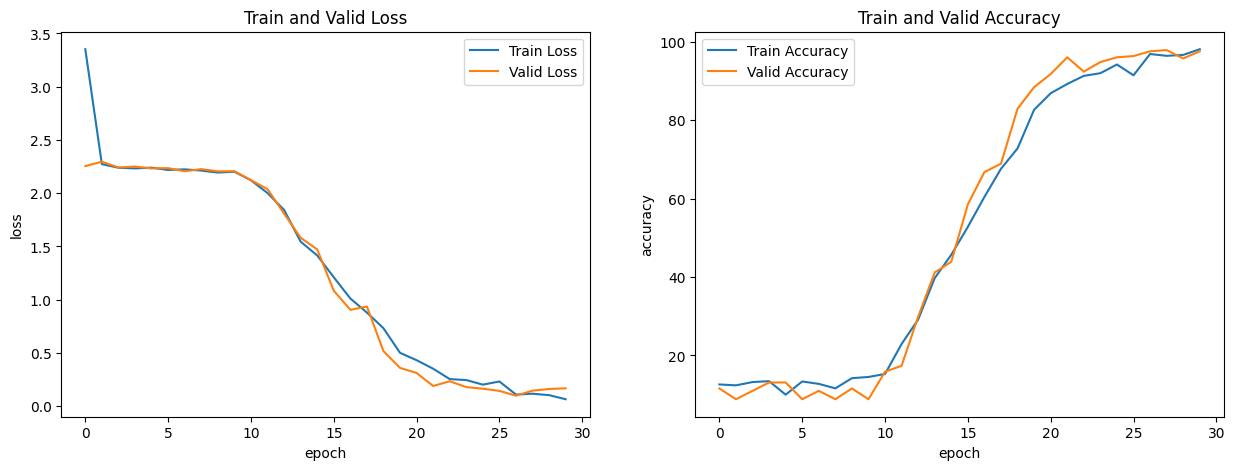

In [18]:
plt_loss_acc(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

# Grading set

Please inference on the testing set data, and store the result as below.

The file name should be **HW2_name_studentid.csv**

ex: HW2_李念祖_N12345678.csv

shout to Harden Li


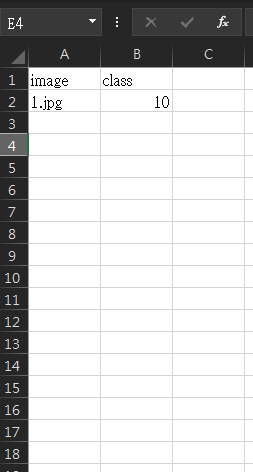


In [19]:
class TestDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.file_names = os.listdir(data_dir)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        file_path = os.path.join(self.data_dir, self.file_names[index])
        image = Image.open(file_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, self.file_names[index]

In [20]:
test_dir = "/content/bangla_banknote_v2/Testing"
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dataset = TestDataset(test_dir, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [21]:
test_dir = "/content/bangla_banknote_v2/Testing"
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dataset = TestDataset(test_dir, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [22]:
result = []
with torch.no_grad():
    for inputs, filenames in test_dataloader:
        inputs = inputs.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        result.extend([(filename, classes[pred.item()]) for filename, pred in zip(filenames, preds)])

df = pd.DataFrame(result, columns=["Filename", "Prediction"])
df.to_csv("predictions.csv", index=False)